# Kalman to the rescue!
## Keras Version
An attempt to change the notebook from [this tutorial](https://towardsdatascience.com/bert-to-the-rescue-17671379687f) to our binarized liar dataset. It uses BERT for binary classification.



In [1]:
!pip install transformers pytorch-nlp

In [2]:
import math
import numpy as np
import pandas as pd
import random as rn
import tensorflow as tf
from transformers import BertTokenizer
from transformers import TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

Using TensorFlow backend.


In [0]:
if False:
  rn.seed(321)
  np.random.seed(321)
  torch.manual_seed(321)
  torch.cuda.manual_seed(321)

## Prepare the Data

In [0]:
def get_data(url):
	'''
	Simple function, that ready in the data, cleans it
	and returns it already split and train and test
	'''
	complete_data = pd.read_csv(url)
	complete_data.dropna()
	texts = complete_data['content'].to_numpy()

	labels = complete_data['label'].to_numpy()

	print('Data will be returned as: ')
	print('x_train, x_val, x_test, y_train, y_val, y_test')
	x_train, x_test, y_train, y_test = train_test_split(texts, labels, train_size=0.8)
	x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8)
	return x_train, x_val, x_test, y_train, y_val, y_test

In [4]:
liar_data_b = 'https://raw.githubusercontent.com/frietz58/euvsvirus/master/datasets/cleaned_data/liar_data_b.csv'
complete_set = 'https://raw.githubusercontent.com/frietz58/euvsvirus/master/datasets/complete-set.csv'
x_train, x_valid, x_test, y_train, y_valid, y_test = get_data(complete_set)
x_train.shape, x_valid.shape, x_test.shape

Data will be returned as: 
x_train, x_val, x_test, y_train, y_val, y_test


((21632,), (5408,), (6760,))

Check balance between classes:

In [5]:
np.mean(y_train), np.mean(y_valid), np.mean(y_test)

(0.4803069526627219, 0.48298816568047337, 0.46597633136094674)

BERT tokenization: BERT was trained using the WordPiece tokenization. It means that a word can be broken down into more than one sub-words. This kind of tokenization is beneficial when dealing with out of vocabulary words, and it may help better represent complicated words. The sub-words are constructed during the training time and depend on the corpus the model was trained on.

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [7]:
tokenizer.tokenize('Hi my name is Pia bitches')

['hi', 'my', 'name', 'is', 'pia', 'bitch', '##es']

The cell below creates the tokenizer, tokenizes each review, adds the special [CLS] token, and then takes only the first 512 tokens for both train and test sets (512 is the maximum sequence size for BERT):

In [8]:
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], x_train))
valid_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], x_valid))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], x_test))

len(train_tokens), len(valid_tokens), len(test_tokens)                   

(21632, 5408, 6760)

Next, we need to convert each token in each review to an id as present in the tokenizer vocabulary. If there’s a token that is not present in the vocabulary, the tokenizer will use the special [UNK] token and use its id. Then we pad all sequences to size 512.

NOTE: post-padding might impede an LSTM classifier!

In [9]:
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
valid_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, valid_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, valid_tokens_ids.shape, test_tokens_ids.shape

((21632, 512), (5408, 512), (6760, 512))

Create attention masks. From BertModel doc:
> Mask to avoid performing attention on padding token indices. Mask values selected in [0, 1]: 1 for tokens that are NOT MASKED, 0 for MASKED tokens.



In [0]:
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
valid_masks = [[float(i > 0) for i in ii] for ii in valid_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

# Baseline

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

In [0]:
baseline_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LogisticRegression(max_iter=10000)).fit(x_train, y_train)

In [0]:
baseline_predicted = baseline_model.predict(x_test)

In [14]:
print(classification_report(y_test, baseline_predicted))

              precision    recall  f1-score   support

           0       0.64      0.69      0.66      1416
           1       0.57      0.52      0.55      1142

    accuracy                           0.61      2558
   macro avg       0.61      0.60      0.60      2558
weighted avg       0.61      0.61      0.61      2558



# Fine-tune BERT
Code from [transformers quick tour](https://github.com/huggingface/transformers#quick-tour-tf-20-training-and-pytorch-interoperability)

In [11]:
print(tf.config.list_physical_devices('GPU'))

# Only check for gpu's with cuda support
print(tf.test.is_gpu_available(cuda_only=True))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [0]:
# Load model from pretrained model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

In [13]:
# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Store input and target as Tensorflow Dataset
train_data = tf.data.Dataset.from_tensor_slices(((train_tokens_ids, train_masks), y_train))
valid_data = tf.data.Dataset.from_tensor_slices(((valid_tokens_ids, valid_masks), y_valid))
test_data = tf.data.Dataset.from_tensor_slices(((test_tokens_ids, test_masks), y_test))

train_data = train_data.shuffle(100).batch(4).repeat(2)
valid_data = valid_data.batch(4)
test_data = test_data.batch(1)

In [15]:
train_data, valid_data, test_data

(<RepeatDataset shapes: (((None, 512), (None, 512)), (None,)), types: ((tf.int64, tf.float32), tf.int64)>,
 <BatchDataset shapes: (((None, 512), (None, 512)), (None,)), types: ((tf.int64, tf.float32), tf.int64)>,
 <BatchDataset shapes: (((None, 512), (None, 512)), (None,)), types: ((tf.int64, tf.float32), tf.int64)>)

In [16]:
# Sanity check: display one sample from the dataset
it = iter(train_data)
next(it)

((<tf.Tensor: shape=(4, 512), dtype=int64, numpy=
  array([[  101,  2004, 13350, ...,     0,     0,     0],
         [  101, 16824,  3633, ...,     0,     0,     0],
         [  101,  2065,  2002, ...,     0,     0,     0],
         [  101,  1037,  7514, ...,     0,     0,     0]])>,
  <tf.Tensor: shape=(4, 512), dtype=float32, numpy=
  array([[1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.]], dtype=float32)>),
 <tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 1, 1])>)

In [17]:
# Sanity check: accuracy should be around the dataset mean
scores = model.evaluate(test_data, steps=100)
print("Loss: {0}, accuracy: {1} ".format(scores[0], scores[1]))

100/100 [==============================] - 5s 53ms/step - loss: 0.6916 - accuracy: 0.5400
Loss: 0.6916468143463135, accuracy: 0.5400000214576721 


In [0]:
# Define callbacks
# TODO Change callback to save every 1000 steps or so
save_best_model = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_freq='epoch')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2, verbose=0)

In [19]:
# Train and evaluate using tf.keras.Model.fit()
out = model.fit(train_data, epochs=10, callbacks=[save_best_model, early_stopping], validation_data=valid_data)

Epoch 1/10
10816/10816 [==============================] - 6130s 567ms/step - loss: 0.3304 - accuracy: 0.8314 - val_loss: 0.3614 - val_accuracy: 0.8373
Epoch 2/10
10816/10816 [==============================] - 6130s 567ms/step - loss: 0.2826 - accuracy: 0.8929 - val_loss: 0.5332 - val_accuracy: 0.8508
Epoch 3/10
10816/10816 [==============================] - 6125s 566ms/step - loss: 0.3127 - accuracy: 0.8934 - val_loss: 0.4608 - val_accuracy: 0.8271


In [20]:
scores = model.evaluate(test_data)
print("Loss: {0}, accuracy: {1} ".format(scores[0], scores[1]))

6760/6760 [==============================] - 364s 54ms/step - loss: 0.4567 - accuracy: 0.8195
Loss: 0.45669153332710266, accuracy: 0.8195266127586365 


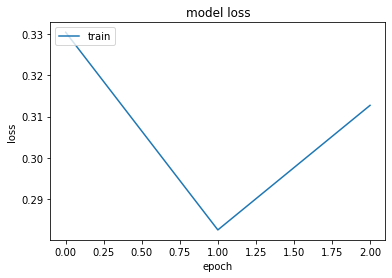

In [21]:
# Visualise the loss
import matplotlib.pyplot as plt

plt.figure()
plt.plot(out.history['loss'])
# plt.plot(out.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
# Load the TensorFlow model in PyTorch for inspection
# model.save_pretrained('./save/')